In [1]:
## Imports

import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
k = 30
nbags = 10
bag_contfactor = .4
seed = 1

In [3]:
## Construct dataset
# 15 bags
# 35 instances/bag
import sys
from PUMILADmain.create_ds import gen_data

bags, bags_labels, X_inst, y_inst = gen_data(k = k, nbags = nbags, bag_contfactor = bag_contfactor, seed = seed)
D= bags
bags = np.array(list(bags.values()))

In [4]:
from dataBag import DataBag
from rewardInfo import RewardInfo

dataBag = DataBag(bags, bags_labels, X_inst, y_inst)
rewardInfo = RewardInfo(len(bags_labels))

clrs = ['b','g','r','c','m','k','y', 'lime','deeppink','aqua','yellow','gray','darkorange','saddlebrown','salmon']

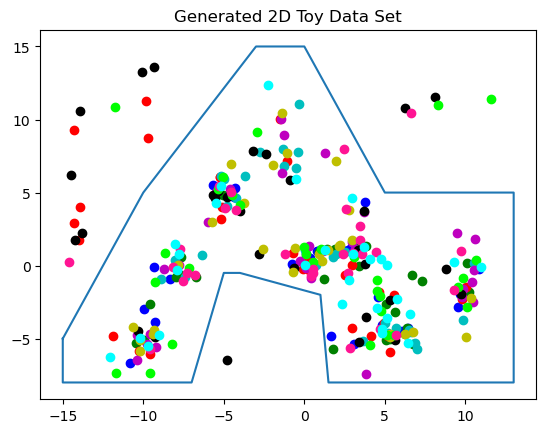

In [5]:
## Create toy data set

from itertools import cycle
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis

'''for bag in range(len(bags)):
    domain = bags[bag]
    anomalies = []
    normals = []
    D[bag] = np.asarray(domain.tolist())

    for idx in range(len(domain)):
        if dataBag.isAnomaly(bag, idx):
            anomalies.append(domain[idx])
        else:
            normals.append(domain[idx])

    anomalies = np.asarray(anomalies)
    normals = np.asarray(normals)
    
    c=next(cycol)
    if (len(normals)>0):
        ax.scatter(normals[:,0], normals[:,1], c=c)#, c= 'b')
    if (len(anomalies)>0):
        ax.scatter(anomalies[:,0], anomalies[:,1],  marker='+', c=c)#,c= 'b')'''

for bag in range(len(bags)):
    domain = bags[bag]
    if (len(domain)>0):
        ax.scatter(domain[:,0], domain[:,1], c=next(cycol))
        
m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
ax.plot(m[:,0], m[:,1])
fig.savefig('img/original.png',bbox_inches='tight')
plt.title('Generated 2D Toy Data Set')
plt.show()
plt.close(fig)


In [6]:
from data import Data
from methods import MABMethod

def getPrediction(alba: MABMethod, data: Data):
    pos = {}
    neg = {}
    probabilities = alba.predict(data, True)
    return probabilities
    '''for key in predictions.keys():
        posdummy = []
        negdummy = []
        for i in range(len(predictions[key])):
            if predictions[key][i]==-1:
                negdummy.append(data.get_domain(key)[i])
            elif predictions[key][i]==1:
                posdummy.append(data.get_domain(key)[i])
        pos[key] = np.asarray(posdummy)
        neg[key] = np.asarray(negdummy)
    return neg, pos, predictions'''

def diff2dd(A, B):
    # https://stackoverflow.com/questions/8317022/get-intersecting-rows-across-two-2d-numpy-arrays
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
        'formats':ncols * [A.dtype]}

    C = np.setdiff1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

def currentPrediction(alba, data, bags, newinstanceKey, instance, labeledPos = None, labeledNeg = None, t=0):
    

    cycol = cycle(clrs)

    fig, ax = plt.subplots( nrows=1, ncols=1 ,figsize=(16,9)) 

    
    m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
    ax.plot(m[:,0], m[:,1])

    for bag in range(len(bags)):
        domain = bags[bag]
        pos = np.asarray(labeledPos[bag])
        neg = np.asarray(labeledNeg[bag])
        domain = diff2dd(domain, pos)
        domain = diff2dd(domain, neg)
        c = next(cycol)

        if (len(domain)>0):
            ax.scatter(domain[:,0], domain[:,1], c=c)
        
        if (len(pos)>0):
            ax.scatter(pos[:,0], pos[:,1], marker = '+', c=c)
        if (len(neg)>0):
            ax.scatter(neg[:,0], neg[:,1], marker = '_', c=c)


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('img/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)



    probabilities = getPrediction(alba, data)
    nrows = 3
    ncols = 4
    fig, axs = plt.subplots( nrows=nrows, ncols=ncols ,figsize=(16,9)) 
   
    m = np.asarray([[-15,-5],[-10,5],[-3,15], [0,15],[5,5],[13,5],[13,-8],[1.5,-8],[1,-2],[-4,-.5],[-5,-.5],[-7,-8],[-15,-8],[-15,-5]])
    for bag in range(len(bags)):
        ax = axs[bag//ncols, bag-ncols*(bag//ncols)]
        ax.plot(m[:,0], m[:,1])
        domain = bags[bag]
        ax.scatter(domain[:,0], domain[:,1], c =probabilities[bag], cmap = 'gray')
        if (bag == newinstanceKey):
            ax.scatter(instance[0], instance[1], c='red')


    plt.title('Iteration '+str(t).zfill(3))
    fig.savefig('colorimg/iteration'+str(t).zfill(3)+'.png',bbox_inches='tight')
    plt.close(fig)


In [7]:
## Create 2 domains
training_data = Data(nbags)
training_data.set_domains_and_labels(D)
query_budget = 30*10
alba = MABMethod(mab="rotting-swa", query_budget=query_budget, verbose=True, rewardInfo=rewardInfo )


In [8]:
t = 0  
labeledPos = {}
labeledNeg = {}
for bag in range(len(bags)):
    labeledNeg[bag] = []
    labeledPos[bag] = []
performance = []

import warnings
warnings.filterwarnings('ignore')

while(t<query_budget):
    queries = alba.fit_query(training_data, True)

    #!!!!!!!
    key,idx = queries[0]
    i = 0
    while dataBag.isLabeled(key,idx):
        i+=1
        key, idx = queries[i]
        
    rewardInfo.chooseArm(key)
    key,idx = queries[i]
    instance = training_data.get_domain(key)[idx]
    lbl = dataBag.getLabel(key, idx)
    training_data.set_new_label(key, idx, lbl)
    training_data.set_last_labeled(key,idx)
    dataBag.label(key,idx)
    if (lbl == 1):
        labeledPos[key].append(instance.tolist())
    else:
        labeledNeg[key].append(instance.tolist())

    currentPrediction(alba, training_data, bags, key, instance, labeledPos,labeledNeg, t)
    
    #performance.append(dataBag.measureAccuracy(predictions))

    t += 1

## window = 10!!!

In [1]:
import cv2
import os

image_folder = 'img'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

image_folder = 'colorimg'
video_name = 'videocolorimg.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
print(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()

['iteration000.png', 'iteration001.png', 'iteration002.png', 'iteration003.png', 'iteration004.png', 'iteration005.png', 'iteration006.png', 'iteration007.png', 'iteration008.png', 'iteration009.png', 'iteration010.png', 'iteration011.png', 'iteration012.png', 'iteration013.png', 'iteration014.png', 'iteration015.png', 'iteration016.png', 'iteration017.png', 'iteration018.png', 'iteration019.png', 'iteration020.png', 'iteration021.png', 'iteration022.png', 'iteration023.png', 'iteration024.png', 'iteration025.png', 'iteration026.png', 'iteration027.png', 'iteration028.png', 'iteration029.png', 'iteration030.png', 'iteration031.png', 'iteration032.png', 'iteration033.png', 'iteration034.png', 'iteration035.png', 'iteration036.png', 'iteration037.png', 'iteration038.png', 'iteration039.png', 'iteration040.png', 'iteration041.png', 'iteration042.png', 'iteration043.png', 'iteration044.png', 'iteration045.png', 'iteration046.png', 'iteration047.png', 'iteration048.png', 'iteration049.png',

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


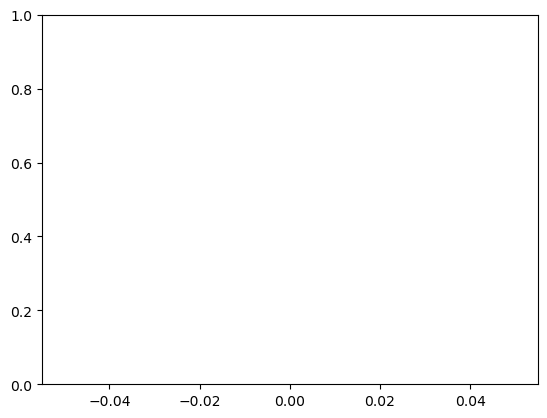

In [10]:
plt.plot(performance)
plt.ylim([0,1])
plt.show()




## Not a lot of difference between random queries or the ALBA paper./weird choice of queries
## This makes sense!
## ALBA first selects the most promising bag and then selects an instance randomly.
## However, both bags have the same distribution, so in practice, it does not change 
# a lot which bag you pick first, because thereafter you pick a random instance and 
# the chance is a lot bigger to pick a negative instance instead of a positive one.
## So basically, ALBA right now (for same distributions) performs the same as random querying.

## The predictions are weird (a queried label is sometimes falsely predicted)
## Does this make sense because we use isolation forests? Or must the code cope with that?

## Rotting bandits paper: formula 1 unclear

[0.06675523857293092, 0.09081618172960053, 0.05335158237973879, 0.02987694196792392, 0.04783126918801882, 0.052060261043106265, 0.03595856774140003, 0.015480741793710335, 0.02388046185464331, 0.01873857682820228, 0.00906469547039927, 0.013542033823105709, 0.007297860583718805, 0.007016732576049862, 0.010220494095238997, 0.028290631314035298, 0.004614162848741418, 0.004805039003086214, 0.00814153728287629, 0.018025644751882872, 0.013914719215331776, 0.003280278676942015, 0.0032710226524585075, 0.002875091747189173, 0.002744564858193313, 0.0022293386743343097, 0.009562510743030318, 0.008606592427293173, 0.0076952530316348215, 0.005791384744411962]
[0.0993975785597288, 0.04295057982487557, 0.04822894630931971, 0.04696628163095969, 0.0771014858536122, 0.03911142706875006, 0.020798853628132708, 0.013357353261086986, 0.013133324735963063, 0.015652789377346075, 0.011755553183521157, 0.018471235281230854, 0.005092409865243703, 0.01097966726990849, 0.009706213897870474, 0.007719457055941113, 0.

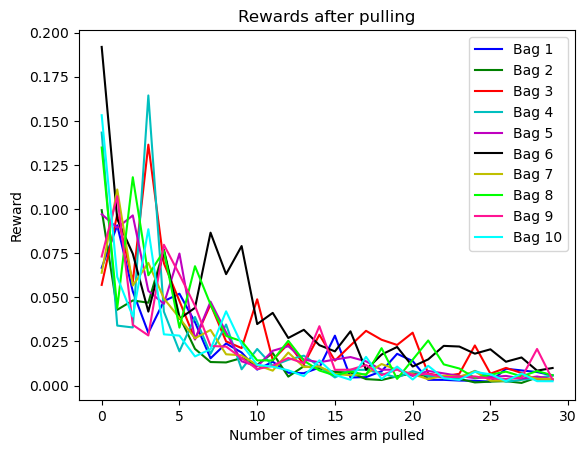

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.11

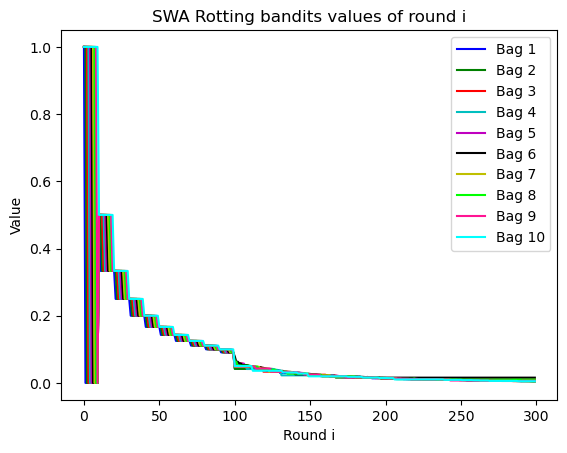

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26

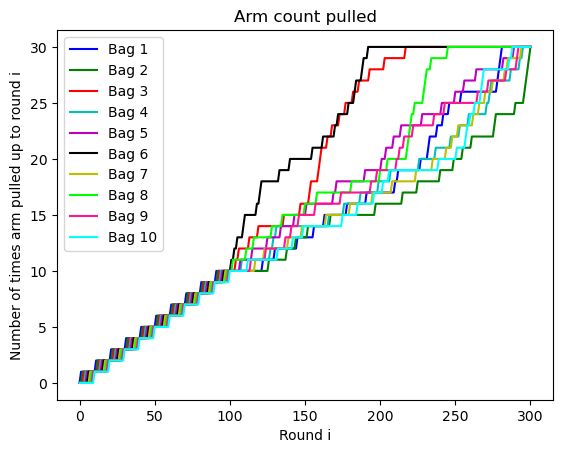

In [11]:
cycol = cycle(clrs)

fig, ax = plt.subplots( nrows=1, ncols=1 ) 

for bag in range(len(bags)):
    rewards = rewardInfo.getRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Rewards after pulling')
plt.ylabel('Reward')
plt.xlabel('Number of times arm pulled')
fig.savefig('img/rewards.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getBanditRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('SWA Rotting bandits values of round i')
plt.ylabel('Value')
plt.xlabel('Round i')
fig.savefig('img/rewardsSWA.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getChosenArm(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(rewards, c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Arm count pulled')
plt.ylabel('Number of times arm pulled up to round i')
plt.xlabel('Round i')
fig.savefig('img/rewardsChosen.png',bbox_inches='tight')
plt.show()
plt.close(fig)


[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.11

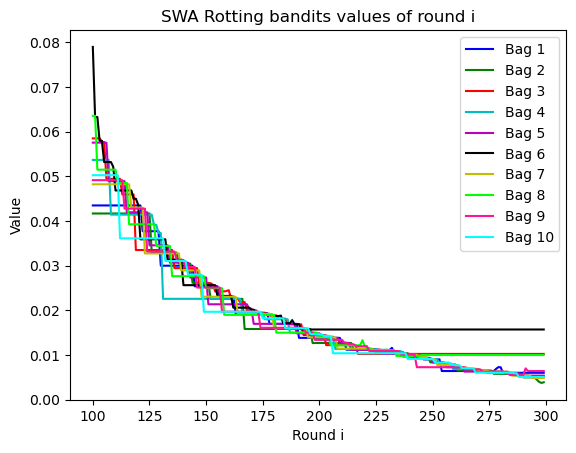

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26

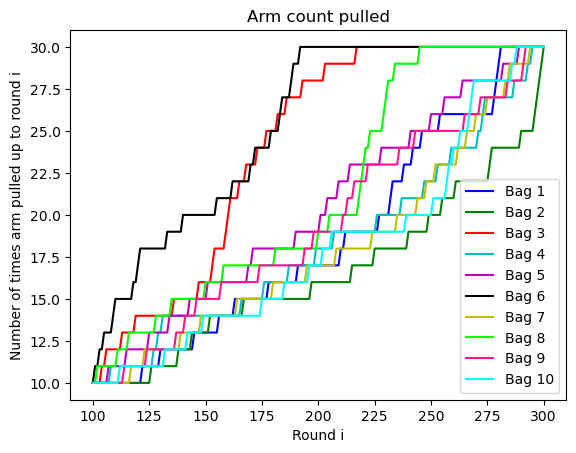

In [12]:
t = rewardInfo.getIterationEndRoundRobin()

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getBanditRewards(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(range(t, t+len(rewards[t:])),rewards[t:], c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('SWA Rotting bandits values of round i')
plt.ylabel('Value')
plt.xlabel('Round i')
fig.savefig('img/rewardsSWAAfterRR.png',bbox_inches='tight')
plt.show()
plt.close(fig)

cycol = cycle(clrs)
fig, ax = plt.subplots( nrows=1, ncols=1 ) 
for bag in range(len(bags)):
    rewards = rewardInfo.getChosenArm(bag)
    print(rewards)
    if (len(rewards)>0):
        ax.plot(range(t, t+len(rewards[t:])),rewards[t:], c=next(cycol))
plt.legend(["Bag "+str(i+1) for i in range(len(bags))])
plt.title('Arm count pulled')
plt.ylabel('Number of times arm pulled up to round i')
plt.xlabel('Round i')
fig.savefig('img/rewardsChosenAfterRR.png',bbox_inches='tight')
plt.show()
plt.close(fig)